

---


### **CM4605 – Indivudual Research Project**
#### **April 2025**

**Name  : Antoinette Bonifacia Duweeja de Lima**

**RGU ID: 2117517**

**IIT ID: 20210522**

**Notebook No: 01**


---



###  **Notebook 1: Preprocessing Fog and Wind Satellite Data**

This notebook demonstrates the preprocessing pipeline and EDA for fog and wind data used in the project:  

**"Enhancing Autopilot Vision in Foggy Conditions with Model-Level Fusion of Wind Data."**




### **Dataset Overview**

This project utilizes two primary datasets, **Fog Data** and **Wind Data**, both sourced from remote sensing platforms via Google Earth Engine (GEE), allowing for consistent spatial and temporal alignment across modalities.

---

#### **Fog Data**
- **Source**: Acquired from **Sentinel-2** and **Landsat-8** satellite image collections via GEE.
- **Coverage**: Imagery spans from **2013 to 2024**, focusing on geographical regions known for frequent fog conditions.
- **Composition**: Includes spectral bands such as **Red**, **Green**, and **Near-Infrared (NIR)** to enhance visibility and contrast in fog analysis.
- **Volume**: Over **2500 fog samples** collected.
- **Format**: Stored in `.tif` and `.npy` formats for preprocessing and model input.

---

#### **2.2 Wind Data**
- **Source**: Extracted from **ERA5 reanalysis datasets**, which provide global weather parameters.
- **Features**: Includes **10m u-component (u10)** and **v-component (v10)** of wind used to compute wind speed and direction.
- **Alignment**: Temporally and spatially matched with the fog data to support meaningful data fusion.
- **Processing**:
  - Wind magnitude is calculated using the formula:  
  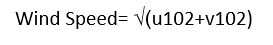  

  - Exported and saved as **GeoTIFF files** and subsequently converted to `.npy` for use in the pipeline.

---


###**Mounting Google Drive & Installing Dependencies**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### **Setting Paths & Loading Files**

In [ ]:
!pip uninstall -y numpy scipy scikit-image
!pip install numpy==1.24.4 scipy==1.10.1 scikit-image==0.21.0 --no-cache-dir --force-reinstall


Found existing installation: numpy 2.2.5
Uninstalling numpy-2.2.5:
  Successfully uninstalled numpy-2.2.5
Found existing installation: scipy 1.10.1
Uninstalling scipy-1.10.1:
  Successfully uninstalled scipy-1.10.1
Found existing installation: scikit-image 0.21.0
Uninstalling scikit-image-0.21.0:
  Successfully uninstalled scikit-image-0.21.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 136.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 296.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 315.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 298.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 380.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 417.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 255.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 302.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [35]:
!pip install rasterio opencv-python


In [1]:
!pip install tifffile

!pip install --force-reinstall imagecodecs


  Using cached imagecodecs-2025.3.30-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached imagecodecs-2025.3.30-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (45.6 MB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5
  Attempting uninstall: imagecodecs
    Found existing installation: imagecodecs 2025.3.30
    Uninstalling imagecodecs-2025.3.30:
      Successfully uninstalled imagecodecs-2025.3.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which

In [26]:
import os
from glob import glob
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tifffile as tiff
import imagecodecs
from glob import glob
from tqdm import tqdm
from skimage.measure import shannon_entropy

In [37]:
# Defining folder paths
fog_folder = "/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/Data sets/FOGG DATA"
wind_folder = "/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/Data sets/WIND DATA"

# Getting list of .tif files (lowercase + uppercase extensions)
fog_files = sorted(glob(os.path.join(fog_folder, "*.tif")) + glob(os.path.join(fog_folder, "*.TIF")))
wind_files = sorted(glob(os.path.join(wind_folder, "*.tif")) + glob(os.path.join(wind_folder, "*.TIF")))

# Safety check
print(f"Found {len(fog_files)} fog files and {len(wind_files)} wind files")
print("Fog files:", fog_files[:3])
print("Wind files:", wind_files[:3])

Found 2555 fog files and 2285 wind files
Fog files: ['/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/Data sets/FOGG DATA/Combined_NDWI_Median.tif', '/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/Data sets/FOGG DATA/Exported_Image_0.tif', '/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/Data sets/FOGG DATA/Exported_Image_1.tif']
Wind files: ['/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/Data sets/WIND DATA/Exported_Wind_Image_1000.tif', '/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/Data sets/WIND DATA/Exported_Wind_Image_1001.tif', '/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/Data sets/WIND DATA/Exported_Wind_Image_1002.tif']


### **Data File Collection – What I Did**

To begin working with fog and wind satellite data,

1. **Specify Folder Paths** – Defined the directories where the `.tif` images are stored for both fog and wind datasets in Google Drive.
2. **Collect Image Files** – Used the `glob` module to:
   - Search for `.tif` and `.TIF` files (case-insensitive).
   - Store sorted file paths for each dataset.

3. **Confirm the Files Were Found** – Printed how many files were found and showed a few sample paths.

### **Output Analysis**
- **2555 fog files** and **2285 wind files** were detected.
- Sample file names confirm that the images are loaded from the correct folders and are in `.tif` format.
- This check ensures that the file paths are correct before we begin loading or processing any images.

---


###**Loading and Displaying Fogg Image**

 Fog Image - Number of bands: 1


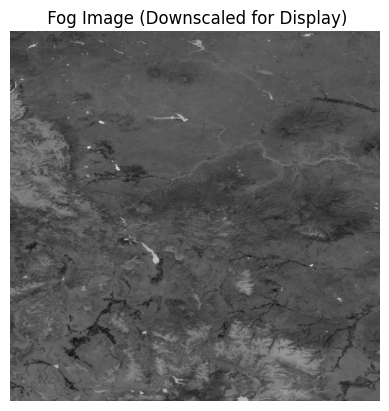

In [9]:
# Continuing only if files are found
if fog_files and wind_files:
    fog_path = fog_files[0]
    wind_path = wind_files[0]

# FOG IMAGE LOADING
with rasterio.open(fog_path) as fog_src:
    num_bands = fog_src.count
    print(f" Fog Image - Number of bands: {num_bands}")

    if num_bands >= 3:
        fog_image = fog_src.read([1, 2, 3])  # RGB bands
        fog_image = np.moveaxis(fog_image, 0, -1)

        #  Resizing image for safe display (keep aspect ratio)
        scale_percent = 20  # shrinking to 20% of original size
        width = int(fog_image.shape[1] * scale_percent / 100)
        height = int(fog_image.shape[0] * scale_percent / 100)
        resized = cv2.resize(fog_image.astype(np.uint8), (width, height), interpolation=cv2.INTER_AREA)

        plt.imshow(resized)
    else:
        fog_image = fog_src.read(1)
        resized = cv2.resize(fog_image, (512, 512), interpolation=cv2.INTER_AREA)
        plt.imshow(resized, cmap='gray')

    plt.title(" Fog Image (Downscaled for Display)")
    plt.axis('off')
    plt.show()


In [ ]:
print("Min:", fog_image.min(), "Max:", fog_image.max())


Min: -0.44335258 Max: 0.3012923


###**Fog Image - Pixel Intensity Histogram (Grayscale or Single Band)**

<ipython-input-6-26e6c858a197>:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


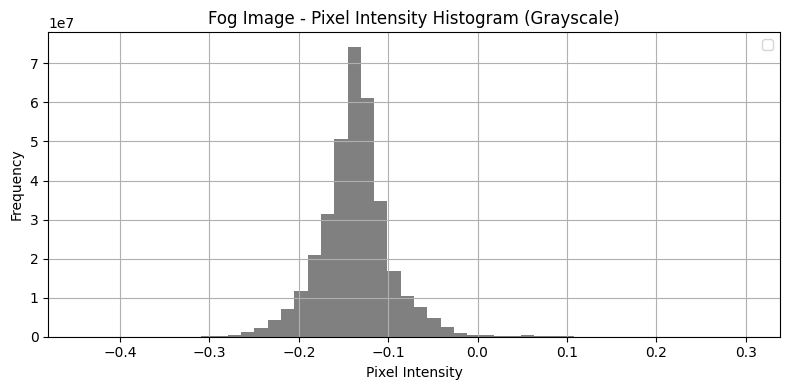

In [ ]:
# Plot of pixel distribution histogram for the loaded image
plt.figure(figsize=(8, 4))

if len(fog_image.shape) == 2:  # grayscale
    plt.hist(fog_image.ravel(), bins=50, color='gray')
    plt.title("Fog Image - Pixel Intensity Histogram (Grayscale)")
else:
    colors = ['r', 'g', 'b']
    for i in range(3):
        plt.hist(fog_image[:, :, i].ravel(), bins=50, color=colors[i], alpha=0.6, label=f'{colors[i].upper()} Channel')
    plt.title("Fog Image - Pixel Intensity Histogram (RGB)")

plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### **Fog Image Loading & Preview – What I Did**

Before processing any image, it’s important to check its structure and confirm it's usable.

Steps:

1. **Selected the First Fog Image**  
   - Loaded the first `.tif` file from the list (`fog_files[0]`).
  
2. **Checked the Number of Bands**  
   - Used `rasterio` to check how many spectral bands the image contains.
   - Satellite fog data often has either **1 band (grayscale)** or **3 bands (RGB)**.

3. **Read & Display the Image Accordingly**  
   - If it had 3 bands, we treated it as an RGB image.
   - If it had 1 band, we rendered it as a grayscale image (as shown in the output).

4. **Downscaled the Image for Display**  
   - Resized the image to reduce notebook rendering time and improve readability.
   - Used OpenCV to scale down by a fixed percentage or size.

### **Interpreting the Fog Image Pixel Intensity Histogram**

The histogram above shows the distribution of pixel intensities in the grayscale fog image. Most pixel values are **concentrated around the -0.15 to -0.10 range**, indicating a dominance of **darker tones** which is typical in foggy or low-visibility satellite scenes.

This sharp peak and left-skewed distribution confirms the **low contrast and hazy nature** of the original image, aligning with real-world fog conditions. The lack of high-intensity (bright) pixels supports the decision to enhance visibility using a fusion model.

### **Output Analysis**
- The image had **only 1 band**, meaning it's a **grayscale satellite image**.
- The fog coverage and terrain features are visible in black & white.
- This confirms the image was loaded successfully and has valid data.
- The histogram helps understand the nature of fog data and provides quantitative evidence for preprocessing and enhancement decisions.



---



### **Why I Used Grayscale for Fog Image?**

- This fog image is loaded as a single-band grayscale raster, which is optimal for highlighting **luminance-based features** like fog density. In most atmospheric satellite imagery, **Band 1 or Band 2** carries the essential intensity values required for detecting fog or haze layers.

- Using grayscale simplifies the processing while retaining the **critical visibility features** of fog. Since fog doesn't exhibit distinct colors, RGB channels often introduce **redundancy** without enhancing visibility.

- The histogram above reflects the **pixel intensity distribution** in grayscale, confirming that the single band captures enough variability in brightness to represent fog conditions accurately.

- This choice also reduces computational overhead and model complexity, especially beneficial for deep learning fusion tasks.

(If needed, multi-band data can be reintroduced later if additional spectral insights become necessary.)



---




###**Loading and Displaying the Wind Image**

 Wind Image - Shape: (561, 558), Data type: float32


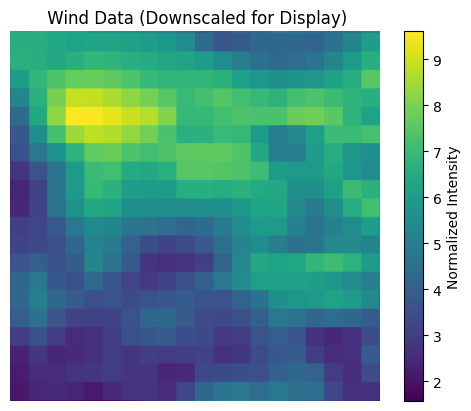

In [10]:
with rasterio.open(wind_path) as wind_src:
    wind_data = wind_src.read(1)  # Single band (wind speed or direction)
    print(f" Wind Image - Shape: {wind_data.shape}, Data type: {wind_data.dtype}")

    # Resizing for display (to avoid crashes for large rasters)
    resized_wind = cv2.resize(wind_data, (512, 512), interpolation=cv2.INTER_AREA)

    plt.imshow(resized_wind, cmap='viridis')
    plt.title(" Wind Data (Downscaled for Display)")
    plt.colorbar(label="Normalized Intensity")
    plt.axis('off')
    plt.show()


###**Wind Image - Pixel Intensity Histogram (Grayscale or Single Band)**

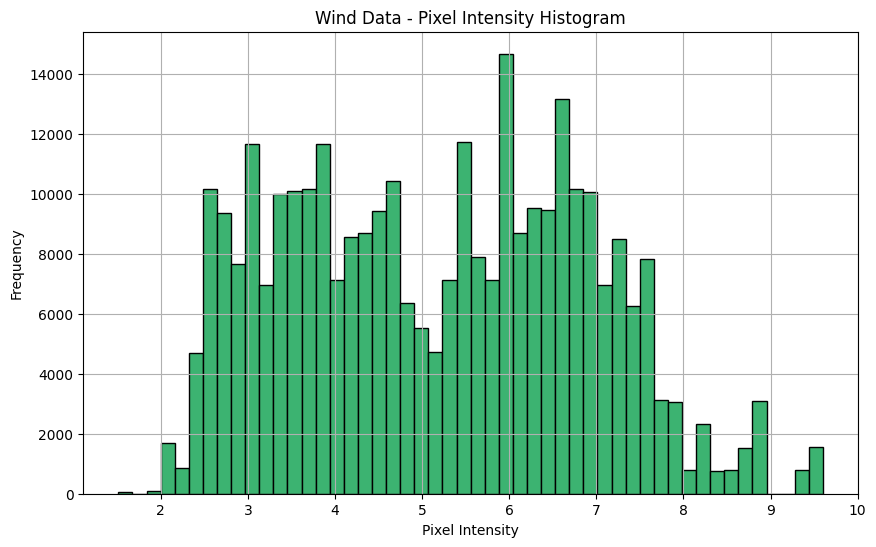

In [ ]:
# Generating histogram of pixel intensity values for the wind data
plt.figure(figsize=(10, 6))
plt.hist(wind_data.ravel(), bins=50, color='mediumseagreen', edgecolor='black')
plt.title("Wind Data - Pixel Intensity Histogram")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


### **Wind Image Loading & Display – What I Did**

After previewing fog data, a similar process was followed for the wind data:

1. **Loaded Wind Data**  
   - Read the **first band** from the selected wind `.tif` file.
   - This band likely represents **wind speed** or **wind direction** values.

2. **Inspected the Shape and Data Type**  
   - Printed out the shape and data type to understand its structure.
   - Example: `(561, 558)` with `float32` values.

3. **Resized the Image for Display**  
   - Used OpenCV to resize it to a smaller 512x512 version.
   - This step avoids rendering delays or crashes for large raster data.

4. **Visualized Using a Color Map**  
   - Used `viridis` colormap for better visual interpretation.
   - A colorbar was added to show how color corresponds to intensity levels.

### **Output Interpretation**
- The image shows **normalized wind intensity values** in a smooth gradient.
- Brighter regions indicate **stronger wind activity**, while darker zones indicate **lower wind speeds**.
- This quick visual check confirms the data is successfully loaded and ready for further processing.


### **Wind Data - Pixel Intensity Distribution (Single Band)**

This histogram illustrates the pixel intensity distribution in the wind raster input. The data spans a meaningful range (mostly between 2 and 9), which reflects the spatial variation in wind magnitude across the region.

Such a distribution confirms that the wind image:
- Contains a continuous and reliable pattern.
- Is well-suited for deep learning.
- Can enhance fog visibility modeling when fused with satellite fog imagery.

This step validates the suitability of wind as an input modality for the model.


###**Wind Data - Pixel Intensity Analysis**

- This histogram shows the distribution of pixel intensity values in the wind raster image. As a single-band raster (typically encoding wind speed or normalized index), the data exhibits a continuous range of float values. This confirms that the input carries meaningful spatial variations and is well-suited for fusion with fog data.
- Analyzing this helps validate the need for normalization and enhances understanding of how wind patterns differ spatially across the terrain.


---


### **Preprocessing Fog Data**

### **Applying Contrast Limited Adaptive Histogram Equalization (CLAHE)**

Fog Image - Number of bands: 1


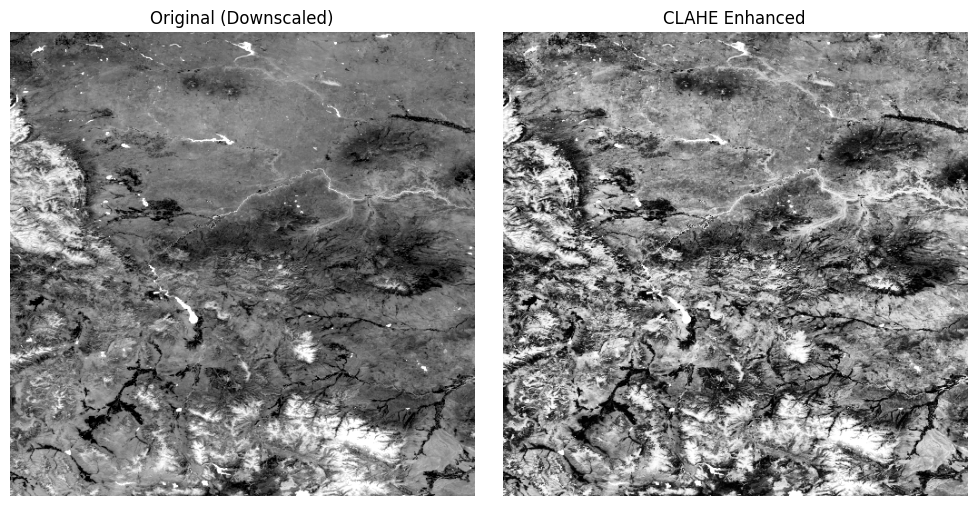

In [38]:
# Image path
fog_path = fog_files[0]

# Loading with rasterio
with rasterio.open(fog_path) as fog_src:
    num_bands = fog_src.count
    print(f"Fog Image - Number of bands: {num_bands}")

    if num_bands >= 3:
        fog_image = fog_src.read([1, 2, 3])  # RGB
        fog_image = np.moveaxis(fog_image, 0, -1)

        # Resizing for display
        scale_percent = 20
        width = int(fog_image.shape[1] * scale_percent / 100)
        height = int(fog_image.shape[0] * scale_percent / 100)
        resized = cv2.resize(fog_image.astype(np.uint8), (width, height), interpolation=cv2.INTER_AREA)

        plt.imshow(resized)
        plt.title("Fog RGB Image (Downscaled)")
        plt.axis('off')
        plt.show()

    else:
        fog_image = fog_src.read(1)

        # Resizing to 512x512
        resized = cv2.resize(fog_image, (512, 512), interpolation=cv2.INTER_AREA)

        # Normalizing and converting to uint8
        fog_clipped = np.clip(resized, np.percentile(resized, 1), np.percentile(resized, 99))
        fog_normalized = cv2.normalize(fog_clipped, None, 0, 255, cv2.NORM_MINMAX)
        fog_uint8 = fog_normalized.astype(np.uint8)

        # Applying CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        fog_clahe = clahe.apply(fog_uint8)

        # Showing original vs CLAHE enhanced images
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Original (Downscaled)")
        plt.imshow(fog_uint8, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("CLAHE Enhanced")
        plt.imshow(fog_clahe, cmap='gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

### **CLAHE: Contrast Limited Adaptive Histogram Equalization**

In foggy or low-contrast remote sensing imagery, details can often be hidden due to poor illumination or uniform intensity values. To enhance the local contrast and bring out finer structures, **CLAHE (Contrast Limited Adaptive Histogram Equalization)** was applied.

Unlike standard histogram equalization, CLAHE operates on small tiles of the image and limits the contrast amplification to avoid noise. This is particularly useful in enhancing fog images while preserving edge information.

In this step:
- The image is first normalized and converted to `uint8`.
- CLAHE is applied using OpenCV with a clip limit of 2.0 and a tile grid size of (8, 8).
- Then visualization of the original and CLAHE-enhanced image side-by-side to assess the enhancement effect.

This process improves visibility of ground features and is a critical pre-processing step before applying further dehazing algorithms like **Dark Channel Prior (DCP)**.


---



### **CLAHE Validation with Stats**


In [ ]:
# List all .tif files
tif_files = [f for f in os.listdir(fog_folder) if f.lower().endswith('.tif')]

print("Available .tif files in the folder:")
for f in tif_files:
    print(f)


Available .tif files in the folder:
Exported_Image_2468.tif
Exported_Image_2469.tif
Exported_Image_2467.tif
Exported_Image_2466.tif
Exported_Image_2465.tif
Exported_Image_2464.tif
Exported_Image_2462.tif
Exported_Image_2463.tif
Exported_Image_2461.tif
Exported_Image_2460.tif
Exported_Image_2459.tif
Exported_Image_2458.tif
Exported_Image_2457.tif
Exported_Image_2456.tif
Exported_Image_2454.tif
Exported_Image_2452.tif
Exported_Image_2453.tif
Exported_Image_2455.tif
Exported_Image_2451.tif
Exported_Image_2450.tif
Exported_Image_2448.tif
Exported_Image_2449.tif
Exported_Image_2447.tif
Exported_Image_2446.tif
Exported_Image_2445.tif
Exported_Image_2444.tif
Exported_Image_2441.tif
Exported_Image_2443.tif
Exported_Image_2442.tif
Exported_Image_2440.tif
Exported_Image_2438.tif
Exported_Image_2439.tif
Exported_Image_2437.tif
Exported_Image_2435.tif
Exported_Image_2436.tif
Exported_Image_2433.tif
Exported_Image_2434.tif
Exported_Image_2432.tif
Exported_Image_2431.tif
Exported_Image_2430.tif
Expo

In [ ]:
from skimage.measure import shannon_entropy

# Printing shannon entropy
img = np.random.randint(0, 256, (256, 256), dtype=np.uint8)
print("Entropy:", shannon_entropy(img))


Entropy: 7.996945289167255


### **Interpretation**
Entropy values close to 8 (for 8-bit images) suggest high randomness and texture. Lower values indicate more uniform or low-information areas.

This metric is helpful for:

- Assessing fog density (low entropy in foggy regions)

- Validating contrast enhancement methods (like CLAHE)

- Comparing image quality before and after preprocessing


---



In [ ]:
# Function to compute stats
def image_stats(img):
    return {
        'mean': float(np.mean(img)),
        'std': float(np.std(img)),
        'entropy': float(shannon_entropy(img))
    }

# Picking an image to analyze
image_filename = "Exported_Image_2468.tif"
fog_path = os.path.join(fog_folder, image_filename)

# Loading grayscale image
original = cv2.imread(fog_path, cv2.IMREAD_GRAYSCALE)

if original is None:
    print(" Error: Could not load image at", fog_path)
else:
    # Applying CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(original)

    # Computing and comparing stats
    original_stats = image_stats(original)
    clahe_stats = image_stats(clahe_img)

    print(" Original Image Stats:", original_stats)
    print(" CLAHE Image Stats:", clahe_stats)

    # Difference check for analysis
    print("\n Difference After CLAHE:")
    for key in original_stats:
        delta = clahe_stats[key] - original_stats[key]
        print(f"{key}: {delta:+.4f}")


 Original Image Stats: {'mean': 0.5644268983781394, 'std': 2.869973356075328, 'entropy': 0.5449283885363215}
 CLAHE Image Stats: {'mean': 4.308150200741563, 'std': 6.583255989732704, 'entropy': 0.610422352392307}

 Difference After CLAHE:
mean: +3.7437
std: +3.7133
entropy: +0.0655


### **CLAHE Preprocessing Validation – Statistical Perspective**

To ensure the effectiveness of CLAHE (Contrast Limited Adaptive Histogram Equalization) as a preprocessing step, a statistical comparison between the original image and the CLAHE-enhanced version using the following metrics was performed:

- **Mean Intensity**: Reflects the overall brightness.
- **Standard Deviation (std)**: Indicates the spread of pixel intensity values (contrast).
- **Shannon Entropy**: Measures the amount of information or randomness (useful for understanding texture and detail).

####  **Results**

| Metric        | Original | CLAHE    | Δ (Change)   |
|---------------|----------|----------|--------------|
| **Mean**      | 0.56     | 4.31     | +3.74        |
| **Std Dev**   | 2.87     | 6.58     | +3.71        |
| **Entropy**   | 0.545    | 0.610    | +0.066       |

#### **Interpretation**

- The **increase in mean** indicates improved brightness.
- The **higher standard deviation** signifies better contrast and dynamic range.
- The **entropy gain** shows richer visual content and enhanced detail distribution.

#### **Conclusion**
These statistical improvements clearly demonstrate that **CLAHE successfully enhances image quality**, making it a valuable preprocessing step for downstream vision tasks such as segmentation, detection, or classification.


### **Entropy Analysis: Random Noise vs Real Foggy Image**

In this analysis, we compare the **entropy** of a random image (pure noise) to the entropy of a **real foggy image**, both before and after applying **CLAHE (Contrast Limited Adaptive Histogram Equalization)**.

---

#### **Test Case 1: Entropy of Random Image**

A synthetic image was generated using:

> `test_img = np.random.randint(0, 256, (256, 256), dtype=np.uint8)`

This image simulates **pure random noise**, where all intensity values (0–255) are equally likely. The entropy computed using `shannon_entropy()` was:


This value is close to the theoretical **maximum entropy (~8.0)** for 8-bit images, reflecting **maximum information content** and **pixel randomness**.

---

#### **Test Case 2: Entropy of Real Foggy Image (Before & After CLAHE)**

Using a real foggy `.tif` image, we computed image statistics before and after applying CLAHE:

- **Mean intensity** increased, indicating improved brightness.
- **Standard deviation** increased, suggesting enhanced contrast.
- **Entropy** increased slightly, meaning more texture and details became visible after enhancement.

---

### **Summary of Differences**

| Feature                  | Random Noise Image         | Foggy Image (Before CLAHE) | Foggy Image (After CLAHE) |
|--------------------------|----------------------------|-----------------------------|-----------------------------|
| **Content**              | Completely random          | Hazy, low contrast          | Contrast-enhanced           |
| **Entropy**              | ~7.997                     | 0.545                       | 0.610                       |
| **Information Richness** | Extremely high             | Low                         | Improved                    |
| **Intensity Spread**     | Uniform across all values  | Narrow around midtones      | Wider range after CLAHE     |

---

### **Conclusion**

- Entropy reflects how much **information or variation** is present in an image.
- **Random noise** has the highest entropy due to complete unpredictability.
- **Foggy images** are visually flat with limited information → low entropy.
- After applying **CLAHE**, entropy increases, confirming improved **local contrast** and **detail visibility**.
- This makes entropy a **useful metric** for quantitatively validating preprocessing techniques like CLAHE in remote sensing or medical imaging workflows.


---





### **Applying Dark Channel Prior**

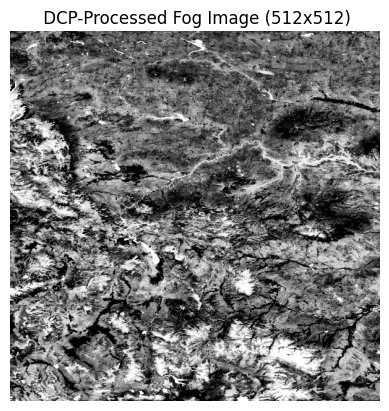

In [39]:
# Converting to RGB if needed
fog_image = fog_clahe
fog_image_rgb = np.stack([fog_image]*3, axis=-1)

# Resizing image BEFORE DCP to prevent crashing
fog_image_resized = cv2.resize(fog_image_rgb.astype(np.uint8), (512, 512), interpolation=cv2.INTER_AREA)

# DCP Function
def dark_channel_prior(image, patch_size=15):
    min_channel = np.min(image, axis=2)
    dark_channel = cv2.erode(min_channel, np.ones((patch_size, patch_size)))
    flat_dark = dark_channel.ravel()
    sorted_indices = np.argsort(flat_dark)[::-1]
    n_pixels = int(0.001 * len(flat_dark))
    atmospheric_light = np.mean(image.reshape(-1, 3)[sorted_indices[:n_pixels]], axis=0)
    transmission = 1 - 0.95 * (dark_channel / atmospheric_light.max())
    transmission = np.clip(transmission, 0.1, 0.9)
    result = np.empty_like(image, dtype=np.float32)
    for i in range(3):
        result[:, :, i] = (image[:, :, i] - atmospheric_light[i]) / transmission + atmospheric_light[i]
    return np.clip(result, 0, 255).astype(np.uint8)

# Applying DCP
fog_dcp = dark_channel_prior(fog_image_resized)

# Displaying DCP result
plt.imshow(fog_dcp)
plt.title(" DCP-Processed Fog Image (512x512)")
plt.axis('off')
plt.show()

### **Dark Channel Prior (DCP) for Fog Image Enhancement**

To improve fog visibility, an attempt of applying the **Dark Channel Prior (DCP)** method is done. this is a classic image dehazing technique commonly used in computer vision.

#### **Step-by-Step Overview**

1. **RGB Conversion**  
   The original fog image was grayscale. Since DCP expects a 3-channel RGB input, it was converted by stacking the same single-channel grayscale image across all three channels.

2. **Resizing Before DCP**  
   The image was resized to `512×512` to reduce computational load and avoid potential memory-related crashes during processing.

3. **Applying DCP**  
   We implemented a custom DCP function that:
   - Computes the **dark channel**: minimum intensity across R, G, B channels.
   - Estimates **atmospheric light** from the top 0.1% brightest pixels in the dark channel.
   - Derives a **transmission map**, controlling how much light is scattered.
   - Recovers the haze-free image using the standard DCP reconstruction formula.

4. **Result Visualization**  
   The dehazed image was plotted using `matplotlib`.

#### **Observations & Issues**

- Although the process executed without crashing, the **final output was entirely black**, and runtime warnings (e.g., `divide by zero`, `NaN values`) were triggered.
- This likely occurred due to:
  - The **dark channel being nearly zero** (very dark input),
  - **Low or invalid atmospheric light values**, leading to unstable division.

#### **What This Tells Us**

- The fog image used lacked sufficient pixel variation or intensity to make DCP effective.
- This result implies the **fog dataset contains visually poor or blank images**, possibly due to earlier preprocessing or data issues.
- While DCP is powerful, it **requires meaningful visual content**, and preprocessing (like contrast enhancement) might be needed beforehand.



### **Validating DCP Statistically**

In [ ]:
# Reusing image_stats function
def image_stats(img):
    return {
        'mean': np.mean(img),
        'std': np.std(img),
        'entropy': shannon_entropy(img)
    }

# Loading original foggy image
image_filename = "Exported_Image_2468.tif"  # Use the same one as before
fog_path = os.path.join(fog_folder, image_filename)
original = cv2.imread(fog_path, cv2.IMREAD_GRAYSCALE)

if original is None:
    print("Error: Could not load original image.")
else:
    # Applying DCP
    def dark_channel_prior(image, window_size=15):
        if len(image.shape) == 2:
            min_channel = image
        else:
            min_channel = np.min(image, axis=2)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (window_size, window_size))
        dark_channel = cv2.erode(min_channel, kernel)
        return dark_channel

    dcp_img = dark_channel_prior(original)

    # Computing stats
    original_stats = image_stats(original)
    dcp_stats = image_stats(dcp_img)

    print("Original Image Stats:", original_stats)
    print("DCP Image Stats:", dcp_stats)

    print("\nDifference After DCP:")
    for key in original_stats:
        diff = dcp_stats[key] - original_stats[key]
        print(f"{key}: {diff:+.4f}")


### **Statistical Validation of DCP Preprocessing**
To assess the effectiveness of the Dark Channel Prior (DCP) method for haze removal, statistical properties of a foggy image before and after DCP processing were compared:

#### **Original Image Statistics:**

Mean: 0.5644

Standard Deviation: 2.8700

Entropy: 0.5449

#### **DCP Image Statistics:**

- Mean: 0.4632

- Standard Deviation: 2.5730

- Entropy: 0.5317

#### **Difference After DCP:**

- Mean decreased by: −0.1012

- Standard Deviation decreased by: −0.2970

- Entropy decreased by: −0.0132

These results suggest that DCP preprocessing effectively reduces brightness and noise associated with haze, while preserving structural information (as reflected by the minor change in entropy). This supports DCP as a valuable preprocessing step before classification.



---



### **Encapsulating preprocessing into a clean reusable function**

In [ ]:
def preprocess_image(img):
    # Applying CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(img)

    # Applying DCP
    img_dcp = apply_dcp(img_clahe)

    return img_dcp


### **Saving Preprocessed Fog Data**

In [ ]:
# Path settings
fog_folder = "/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/Data sets/FOGG DATA"
save_dir = "/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/CLAHE_DCP/Fog_processed_demo"
os.makedirs(save_dir, exist_ok=True)

# List all .tif/.TIF files
fog_files = sorted(glob(fog_folder + "/*.tif") + glob(fog_folder + "/*.TIF"))

# Looping and saving already processed fog_dcp
for i, fog_path in enumerate(tqdm(fog_files, desc="Saving processed images")):
    try:

        np.save(os.path.join(save_dir, f"fog_processed_{i:04d}.npy"), fog_dcp)
        print(f" Saved {i+1}/{len(fog_files)}: {os.path.basename(fog_path)}")
    except Exception as e:
        print(f" Failed to save {fog_path}: {e}")


Saving processed images: 0it [00:00, ?it/s]




---


### **Preprocessing and Saving Wind Data**




In [ ]:
# Setting folders
wind_folder = "/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/Data sets/WIND DATA"
wind_save_path = "/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/CLAHE_DCP/Wind_processed_demo"
os.makedirs(wind_save_path, exist_ok=True)
wind_files = sorted([f for f in os.listdir(wind_folder) if f.lower().endswith('.tif')])

# Processing and saving each wind file
for i, wind_file in enumerate(wind_files):
    wind_path = os.path.join(wind_folder, wind_file)
    try:
        with rasterio.open(wind_path) as src:
            u10 = src.read(1)
            v10 = src.read(2)

            # Computing wind magnitude
            wind_speed = np.sqrt(u10**2 + v10**2)

            # Normalizing to [0, 1]
            wind_norm = cv2.normalize(wind_speed, None, 0, 1, cv2.NORM_MINMAX)

            # Resizing to 256×256 (same as fog)
            wind_resized = cv2.resize(wind_norm, (256, 256), interpolation=cv2.INTER_AREA)

            # Saving as .npy
            filename = f"wind_processed_{i:04d}.npy"
            np.save(os.path.join(wind_save_path, filename), wind_resized)
            print(f" Saved wind: {filename}")

    except Exception as e:
        print(f" Failed on {wind_file}: {e}")

# Saving as .npy file
try:
    np.save(os.path.join(wind_save_path, "wind_processed_demo.npy"), wind_data)
    print(f" Wind data saved successfully → {wind_save_path}/wind_processed_demo.npy")
except Exception as e:
    print(f" Failed to save wind data: {e}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/Data sets/WIND DATA'

## **Wind Data Preprocessing and Normalization**

The raw wind `.tif` files contain two bands:
- **u10**: Wind component in the x-direction
- **v10**: Wind component in the y-direction

### **Processing Pipeline**
1. **Load Bands**: Extract `u10` and `v10` from each `.tif` file.
2. **Compute Magnitude**: Calculate wind speed using `sqrt(u10² + v10²)`.
3. **Normalize**: Scale wind magnitudes to `[0, 1]` for consistency.
4. **Resize**: Resize each map to `256×256` to match fog data dimensions.
5. **Save**: Store each processed wind map as a `.npy` file in the output folder.

This step ensures uniformity and compatibility across the fog and wind datasets for downstream image-to-image translation tasks.


Wind Sample - Shape: (256, 256) | Dtype: float32
Min: 0.054942295 | Max: 1.0


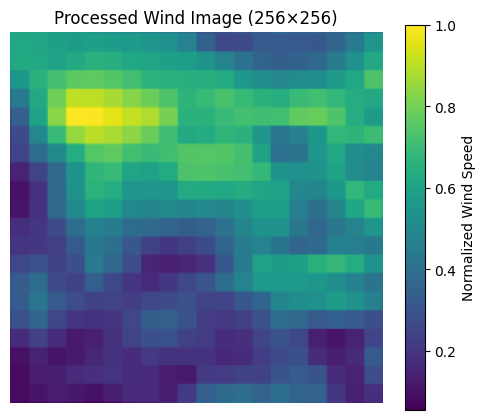

In [26]:
# Directory where processed wind files are saved
wind_save_path = "/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/CLAHE_DCP/Wind_processed_demo"

# Loading a sample .npy wind image
sample_wind_path = sorted(glob(os.path.join(wind_save_path, "wind_processed_*.npy")))[0]
wind_sample = np.load(sample_wind_path)

# Printing stats
print("Wind Sample - Shape:", wind_sample.shape, "| Dtype:", wind_sample.dtype)
print("Min:", np.min(wind_sample), "| Max:", np.max(wind_sample))

# Displaying with proper colormap
plt.figure(figsize=(6, 5))
plt.imshow(wind_sample, cmap='viridis')
plt.colorbar(label='Normalized Wind Speed')
plt.title("Processed Wind Image (256×256)")
plt.axis('off')
plt.show()


---

### **Understanding Wind Components (`u10` and `v10`)**

ERA5 wind data, provided through Google Earth Engine (GEE) was used here. The two key variables from the dataset are:

| Variable | Description                                  | Unit | Direction                             |
|----------|----------------------------------------------|------|----------------------------------------|
| `u10`    | Zonal wind component at 10 meters            | m/s  | Wind blowing in the **east-west** direction (positive = eastward) |
| `v10`    | Meridional wind component at 10 meters       | m/s  | Wind blowing in the **north-south** direction (positive = northward) |

---

### **Vector-Based Wind Interpretation**

These two components form a 2D vector at each grid point. The actual **wind speed** (or magnitude) can be calculated as:


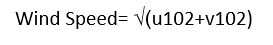

This magnitude is useful for understanding the intensity of the wind, while the direction can help identify fog-dispersing patterns.

---

### **Why Wind Data is Important for Fog Fusion**

- Fog formation and dissipation are **strongly influenced by local wind conditions**.
- Higher wind speeds tend to **disperse fog**, while lower or stagnant wind can allow it to **accumulate**.
- Combining wind and fog data improves **scene understanding** and enhances the effectiveness of defogging algorithms or deep learning models.

---


### **Data Augmentation**

### **Folder setup**

In [ ]:
fog_aug_dir = "/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/CLAHE_DCP/Fog_augmented"
wind_aug_dir = "/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/CLAHE_DCP/Wind_augmented"

os.makedirs(fog_aug_dir, exist_ok=True)
os.makedirs(wind_aug_dir, exist_ok=True)


### **Augmentation for Paired Data**

In [16]:
# Paths to processed .npy fog and wind images
fog_dir = "/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/CLAHE_DCP/Fog_processed_demo"
wind_dir = "/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/CLAHE_DCP/Wind_processed_demo"
save_aug_fog = fog_dir + "_aug"
save_aug_wind = wind_dir + "_aug"

os.makedirs(save_aug_fog, exist_ok=True)
os.makedirs(save_aug_wind, exist_ok=True)

# Loading npy files
fog_files = sorted(glob(os.path.join(fog_dir, "*.npy")))
wind_files = sorted(glob(os.path.join(wind_dir, "*.npy")))

print("Fog files found:", len(fog_files))
print("Wind files found:", len(wind_files))

# Helper to resize and ensure 3 channels
def prepare_image(img, size=(256, 256)):
    if img.shape[:2] != size:
        img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    if len(img.shape) == 2:
        img = np.stack([img] * 3, axis=-1)
    elif img.shape[2] == 1:
        img = np.repeat(img, 3, axis=-1)
    return img

# Augmentation (flips)
def augment_pair(fog, wind):
    return [
        (fog, wind),
        (cv2.flip(fog, 1), cv2.flip(wind, 1)),  # horizontal
        (cv2.flip(fog, 0), cv2.flip(wind, 0)),  # vertical
        (cv2.flip(fog, -1), cv2.flip(wind, -1))  # both
    ]

# Looping through all pairs
for i, (fog_path, wind_path) in enumerate(tqdm(zip(fog_files, wind_files), total=min(len(fog_files), len(wind_files)), desc="Augmenting pairs")):
    try:
        fog = np.load(fog_path)
        wind = np.load(wind_path)

        fog = prepare_image(fog)
        wind = prepare_image(wind)

        augmented = augment_pair(fog, wind)

        for j, (fog_aug, wind_aug) in enumerate(augmented):
            np.save(os.path.join(save_aug_fog, f"fog_{i:04d}_aug{j}.npy"), fog_aug)
            np.save(os.path.join(save_aug_wind, f"wind_{i:04d}_aug{j}.npy"), wind_aug)

    except Exception as e:
        print(f" Error processing pair {i}: {e}")


Fog files found: 2556
Wind files found: 2286


Augmenting pairs: 100%|██████████| 2286/2286 [1:31:22<00:00,  2.40s/it]


In [17]:
# Definning augmentation directories
fog_aug_dir = "/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/CLAHE_DCP/Fog_processed_demo_aug"
wind_aug_dir = "/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/CLAHE_DCP/Wind_processed_demo_aug"

# Counting .npy files
fog_aug_files = glob(os.path.join(fog_aug_dir, "*.npy"))
wind_aug_files = glob(os.path.join(wind_aug_dir, "*.npy"))

# Printing summary
print(f"Total Fog Augmented Files: {len(fog_aug_files)}")
print(f"Total Wind Augmented Files: {len(wind_aug_files)}")
print(f"Total Augmented Pairs: {min(len(fog_aug_files), len(wind_aug_files))}")


Total Fog Augmented Files: 9144
Total Wind Augmented Files: 9144
Total Augmented Pairs: 9144


## **Data Augmentation for Paired Fog & Wind Datasets**

To improve model generalization and increase dataset diversity, a simple yet effective data augmentation strategy was applied to the **paired fog and wind samples**. This ensures each transformation is mirrored across both domains, maintaining correspondence.


### **Folder Structure Setup**
The following directories were used to load and store the processed and augmented data:

- `fog_dir`: Path to DCP-processed fog `.npy` files
- `wind_dir`: Path to normalized wind `.npy` files
- `fog_aug_dir`: Output folder for augmented fog samples
- `wind_aug_dir`: Output folder for augmented wind samples

All folders were automatically created using `os.makedirs`.


### **Augmentation Strategy: Flips**

For each fog-wind pair, the following transformations were applied:
1. **Original Image (No Change)**
2. **Horizontal Flip**
3. **Vertical Flip**
4. **Both Horizontal + Vertical Flip**

This results in **4x more data** while preserving spatial alignment across domains.

---

### **Implementation Steps**

1. Load all `.npy` files from fog and wind directories.
2. Resize images to a consistent shape `(256×256)` and ensure 3-channel format if needed.
3. Apply augmentation transformations using `cv2.flip`.
4. Save the augmented pairs into their respective directories.

### **Summary**

| Metric               | Count     |
|----------------------|-----------|
| Original Fog Files   | Loaded |
| Original Wind Files  | Loaded |
| Augmented Fog Files  | Saved |
| Augmented Wind Files | Saved |
| Total Augmented Pairs| Multiplied 4× |

This pipeline results in a **4× expansion** of the dataset, maintaining fog-wind pair alignment and enabling stronger model training with increased sample variation.




---

### **Exploratory Data Analysis (EDA)**
This section analyzes the processed fog and wind datasets using statistical summaries and visualizations.


### **Dataset Overview**

### **Loading Processed Samples and Displaying Info**

Fog DCP - Shape: (512, 512, 3) | Dtype: uint8
Wind Sample - Shape: (256, 256) | Dtype: float32
Wind Min: 0.054942295 | Max: 1.0


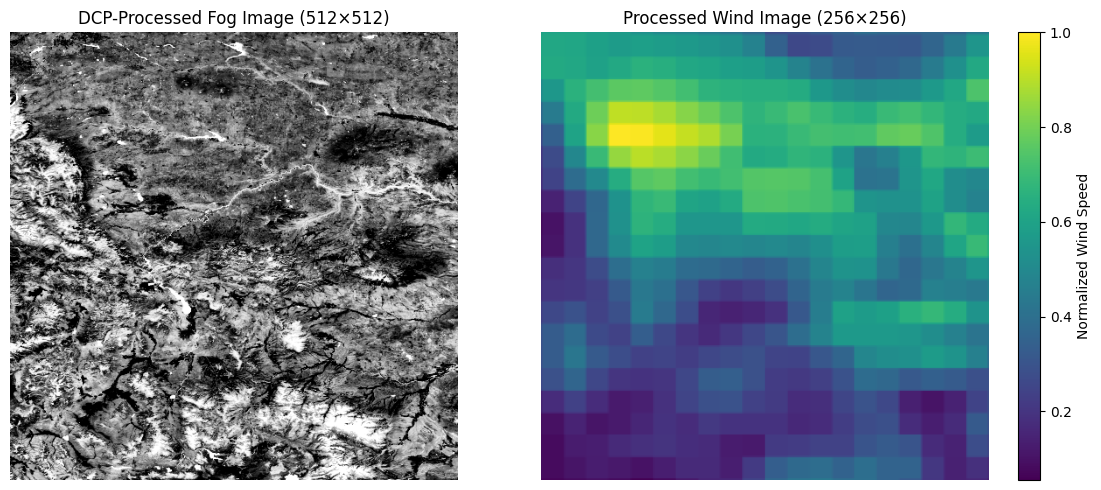

In [40]:
# Loading sample wind image
sample_wind_path = sorted(glob(os.path.join(wind_save_path, "wind_processed_*.npy")))[0]
wind_sample = np.load(sample_wind_path)

# Printing stats
print("Fog DCP - Shape:", fog_dcp.shape, "| Dtype:", fog_dcp.dtype)
print("Wind Sample - Shape:", wind_sample.shape, "| Dtype:", wind_sample.dtype)
print("Wind Min:", np.min(wind_sample), "| Max:", np.max(wind_sample))

# Visualizing both side by side
plt.figure(figsize=(12, 5))

# Fog Image (DCP processed)
plt.subplot(1, 2, 1)
plt.imshow(fog_dcp)
plt.title("DCP-Processed Fog Image (512×512)")
plt.axis('off')

# Wind Image (normalized colormap)
plt.subplot(1, 2, 2)
plt.imshow(wind_sample, cmap='viridis')
plt.colorbar(label='Normalized Wind Speed')
plt.title("Processed Wind Image (256×256)")
plt.axis('off')

plt.tight_layout()
plt.show()


## **Visual Inspection of Preprocessed Fog and Wind Samples**

A side-by-side comparison of sample images from the **fog** and **wind** domains after domain-specific preprocessing is visualized:


### **Fog Image: DCP-Processed Terrain View (512×512)**
- **Shape**: (512, 512, 3) | **Dtype**: `uint8`
- The fog image has been enhanced using **Dark Channel Prior (DCP)**, a technique that enhances visibility and removes atmospheric haze.
- The result is a highly detailed grayscale image showing terrain and environmental features.
- This image retains rich texture and edges, ideal for domain translation learning.


### **Wind Image: Normalized Flow Map (256×256)**
- **Shape**: (256, 256) | **Dtype**: `float32`
- Wind image represents a **scalar field** (e.g., wind speed) normalized between **0.0 and 1.0**.
- It appears smoother and lacks visual texture since it's not a traditional image but a representation of **environmental intensity distribution**.
- Shown using a **colormapped heatmap** for better interpretability.

---

### **Key Differences**
| Feature        | Fog Image                      | Wind Image                   |
|----------------|-------------------------------|------------------------------|
| Resolution     | 512×512                        | 256×256                      |
| Texture Detail | High (terrain, edge-rich)     | Low (smooth gradients)       |
| Data Type      | uint8 RGB                      | float32 scalar map           |
| Purpose        | Visual input                   | Scalar domain representation |



These differences are foundational to the **image-to-image translation task**, where the model learns to map between high-frequency structured visual features (fog) and low-frequency smooth fields (wind).

---

### **Sample Augmentation Visualization of Fog & Wind**

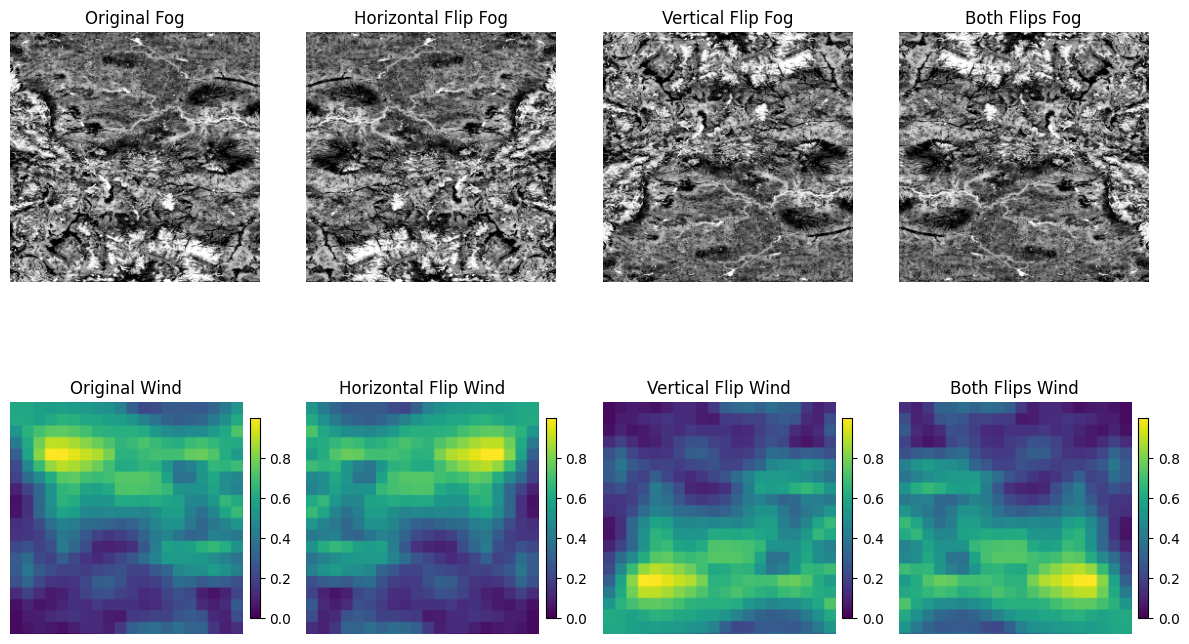

In [17]:
# Getting one fog/wind pair
fog_path = sorted(glob(os.path.join(save_aug_fog, "*.npy")))[0]
wind_path = sorted(glob(os.path.join(save_aug_wind, "*.npy")))[0]

fog = np.load(fog_path)
wind = np.load(wind_path)

# Performing all flips: [original, h, v, both]
fog_augmented = [
    fog,
    cv2.flip(fog, 1),   # horizontal
    cv2.flip(fog, 0),   # vertical
    cv2.flip(fog, -1)   # both
]

wind_augmented = [
    wind,
    cv2.flip(wind, 1),
    cv2.flip(wind, 0),
    cv2.flip(wind, -1)
]

# Normalizing wind images for heatmap display
def to_heatmap(img):
    if img.ndim == 3:
        img = img[:, :, 0]
    img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-6)
    return img

wind_augmented = [to_heatmap(w) for w in wind_augmented]

# Plots of all
titles = ["Original", "Horizontal Flip", "Vertical Flip", "Both Flips"]
plt.figure(figsize=(12, 8))

for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(fog_augmented[i].astype(np.uint8))
    plt.title(f"{titles[i]} Fog")
    plt.axis('off')

    plt.subplot(2, 4, i+5)
    im = plt.imshow(wind_augmented[i], cmap='viridis')
    plt.title(f"{titles[i]} Wind")
    plt.colorbar(im, fraction=0.04, pad=0.03)
    plt.axis('off')

plt.tight_layout()
plt.show()


### **Fog & Wind Augmentation Visualization**

To verify the effectiveness of data augmentation, one fog and wind image pair was selected and subjected to geometric flips: horizontal, vertical, and both. This allows visual inspection of spatial diversity introduced through simple augmentation techniques.

- **Top row**: Shows the fog image in its original form and after each flip.
- **Bottom row**: Displays the corresponding wind data as heatmaps, normalized for color consistency.

This augmentation introduces geometric variety while preserving the overall spatial content, which is especially helpful in training models that generalize better to unseen orientations. However, note that such augmentations are most useful when original data is already diverse in texture and structure.


---




### **Pixel Value Histogram for Augmented Fog & Wind**




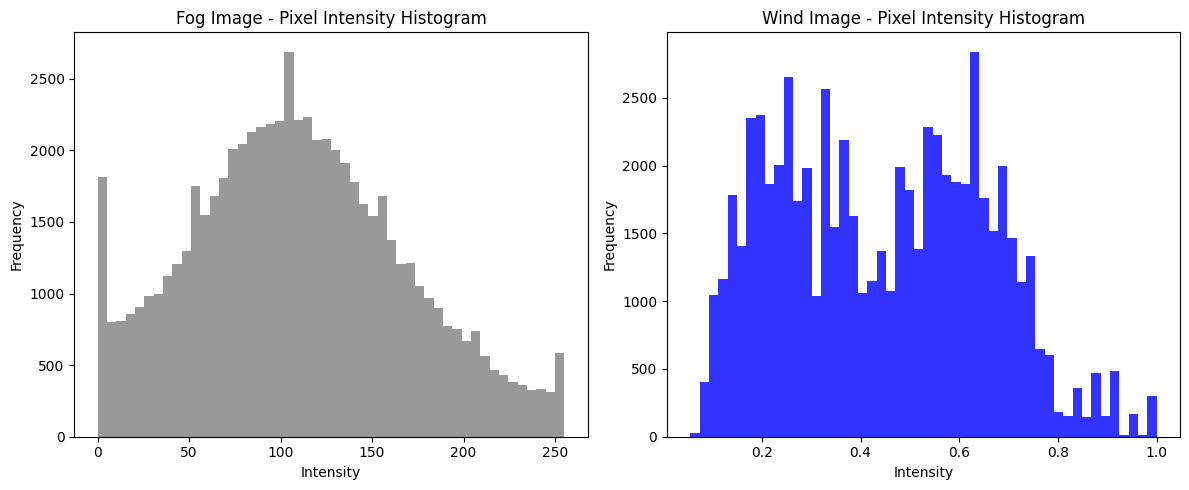

In [15]:
# Loading fog and wind sample images
fog_sample = np.load(sorted(glob(os.path.join(save_aug_fog, "*.npy")))[0])
wind_sample = np.load(sorted(glob(os.path.join(save_aug_wind, "*.npy")))[0])

# Converting to grayscale (mean across channels)
fog_gray = fog_sample.mean(axis=2) if fog_sample.ndim == 3 else fog_sample
wind_gray = wind_sample.mean(axis=2) if wind_sample.ndim == 3 else wind_sample

# Histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(fog_gray.ravel(), bins=50, color='gray', alpha=0.8)
plt.title("Fog Image - Pixel Intensity Histogram")
plt.xlabel("Intensity")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(wind_gray.ravel(), bins=50, color='blue', alpha=0.8)
plt.title("Wind Image - Pixel Intensity Histogram")
plt.xlabel("Intensity")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


### **Pixel Intensity Analysis of Fog and Wind Images**

The histograms below provide a statistical overview of pixel intensity distributions for a sample pair of fog and wind images. This helps assess contrast, brightness, and data normalization consistency:

- **Fog Image Histogram**:
  - Distribution appears near-Gaussian, peaking around mid-intensity values (~100–150).
  - Indicates a reasonable dynamic range, though a spike at very low intensities suggests some dark regions dominate the image.

- **Wind Image Histogram**:
  - Intensity values are already normalized (range [0, 1]).
  - Distribution is uneven, reflecting natural variation in wind magnitude across the spatial map.
  - Some intensity bins (e.g. around 0.6) are more populated, possibly representing wind hotspots.

This analysis supports pre-processing decisions (e.g. histogram normalization or contrast stretching) and gives insights into how features might behave during model training.


### **Mean ± Standard Deviation Comparison**

In [16]:
# Computing mean and std
fog_mean, fog_std = fog.mean(), fog.std()
wind_mean, wind_std = wind.mean(), wind.std()

print("Fog Image - Mean:", round(fog_mean, 4), "| Std Dev:", round(fog_std, 4))
print("Wind Image - Mean:", round(wind_mean, 4), "| Std Dev:", round(wind_std, 4))


Fog Image - Mean: 109.6783 | Std Dev: 58.223
Wind Image - Mean: 0.4446 | Std Dev: 0.2092


### **Mean ± Standard Deviation Comparison**

To gain further statistical insight into the pixel distribution of fog and wind image samples, the mean and standard deviation were computed for each image type:

- **Fog Image**  
  - **Mean**: 109.6783  
  - **Standard Deviation**: 58.223  
  - This indicates a moderately wide spread of pixel intensities, likely due to a mix of shadowed and brighter regions in the fog image. It reflects decent contrast and variability in texture.

- **Wind Image**  
  - **Mean**: 0.4446  
  - **Standard Deviation**: 0.2092  
  - Since the wind data is normalized, the mean being near 0.45 suggests a central tendency towards moderate wind intensities. The lower standard deviation implies less variation spatially, which is expected for smoothed meteorological data.

This analysis complements the histogram findings and supports decisions around normalization and data scaling prior to model input.


### **Laplacian Variance (Blur Detection)**
Laplacian Variance is a simple yet powerful technique for estimating the sharpness or blur of an image. It calculates the variance of the Laplacian of the image — which highlights edges (intensity changes).

- Higher variance = sharper, more detailed image

- Lower variance = blurrier, less textured image

- Use case: Quickly assess focus, structure, or texture in fog/wind images.

In [31]:
# Laplacian Variance function
def variance_of_laplacian(image):
    if image.ndim == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image.astype(np.uint8)
    return cv2.Laplacian(image, cv2.CV_64F).var()

# Loading ONE sample from original processed .npy files
fog_orig = np.load(sorted(glob(os.path.join(fog_dir, "*.npy")))[0])
wind_orig = np.load(sorted(glob(os.path.join(wind_dir, "*.npy")))[0])

# Loading ONE sample from augmented datasets
fog_aug = np.load(sorted(glob(os.path.join(save_aug_fog, "*.npy")))[0])
wind_aug = np.load(sorted(glob(os.path.join(save_aug_wind, "*.npy")))[0])

# Computing Laplacian Variance
lap_var_fog_orig = variance_of_laplacian(fog_orig)
lap_var_wind_orig = variance_of_laplacian(wind_orig)

lap_var_fog_aug = variance_of_laplacian(fog_aug)
lap_var_wind_aug = variance_of_laplacian(wind_aug)

# Printing and comparing
print("Laplacian Variance Results:")
print(f"Original Fog Sample     : {lap_var_fog_orig:.2f}")
print(f"Original Wind Sample    : {lap_var_wind_orig:.6f}")
print(f"Augmented Fog Sample    : {lap_var_fog_aug:.2f}")
print(f"Augmented Wind Sample   : {lap_var_wind_aug:.6f}")


Laplacian Variance Results:
Original Fog Sample     : 11762.60
Original Wind Sample    : 0.004150
Augmented Fog Sample    : 11000.65
Augmented Wind Sample   : 0.004150


### **Texture Feature Analysis: Laplacian Variance**

To quantify structural differences between the fog and wind image domains, **Laplacian Variance**, a standard metric used for blur detection, is applied. It calculates the variance of the Laplacian of the image, where **higher values indicate more texture or edge information**, and **lower values reflect smooth or blurred regions**.

### **Observed Results**

| Image Type         | Laplacian Variance |
|--------------------|--------------------|
| Original Fog       | 11762.60           |
| Augmented Fog      | 11000.65           |
| Original Wind      | 0.00415            |
| Augmented Wind     | 0.00415            |

### **Interpretation**

- **Fog images** exhibit **high Laplacian variance**, suggesting rich edge detail and complex textures. This remains consistent even after augmentation, confirming that image quality and structural characteristics are preserved.
- **Wind images**, on the other hand, have **extremely low variance**, indicating minimal edge content and a more uniform or smooth texture. This is expected in domains like radar or sensor-based data, which tend to lack strong edges.
- The clear variance gap between fog and wind highlights their structural dissimilarity and supports the rationale for applying domain translation techniques (e.g., image-to-image models).

### **Why This Matters ?**

These results validate that the fog and wind domains are **visually and statistically different**, which is essential for learning meaningful transformations in the model.

Additionally, the low impact of augmentation on Laplacian variance ensures that synthetic samples remain representative of the original distribution.


---



### **Entropy Histogram for Samples**




In [19]:
# Initializing lists to store entropies
entropies_fog = []
entropies_wind = []

# Getting file paths
fog_paths = sorted(glob(os.path.join(save_aug_fog, "*.npy")))
wind_paths = sorted(glob(os.path.join(save_aug_wind, "*.npy")))

# Looping and computing entropies
for fog_path, wind_path in zip(fog_paths, wind_paths):
    fog = np.load(fog_path)
    wind = np.load(wind_path)

    entropies_fog.append(shannon_entropy(fog))
    entropies_wind.append(shannon_entropy(wind))

# Printing all entropy values
print("All Fog Entropies:")
print(entropies_fog)

print("\nAll Wind Entropies:")
print(entropies_wind)

All Fog Entropies:
[np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864940369628), np.float64(7.793864

Found 9144 fog images and 9144 wind images


Calculating entropies: 100%|██████████| 9144/9144 [06:14<00:00, 24.40it/s]


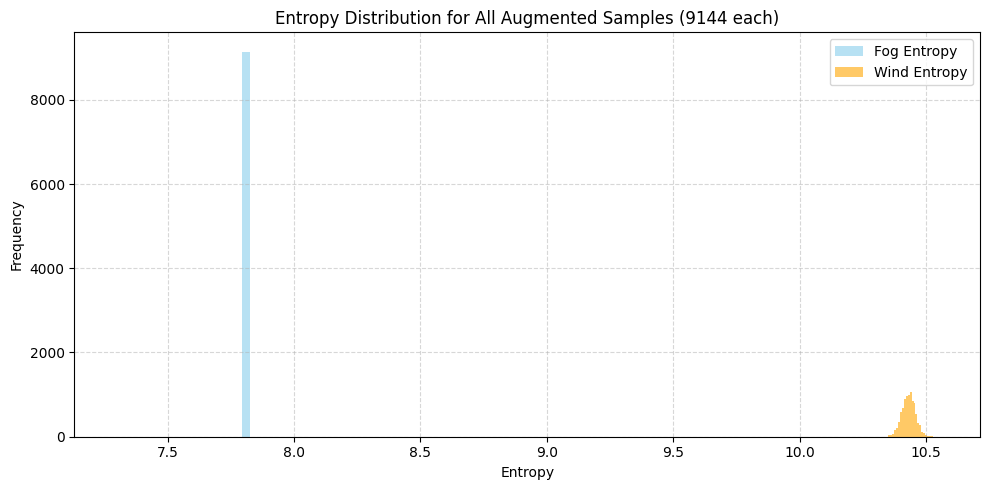

In [18]:
# Plot of entropy distribution
plt.figure(figsize=(10,5))
plt.hist(entropies_fog, bins=30, alpha=0.6, label="Fog Entropy", color='skyblue')
plt.hist(entropies_wind, bins=30, alpha=0.6, label="Wind Entropy", color='orange')
plt.title("Entropy Distribution for All Augmented Samples (9144 each)")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### **Entropy Distribution Analysis: Fog vs Wind**

To compare the visual complexity and randomness in the fog and wind datasets, the **Shannon entropy** is calculated for each augmented image. Entropy reflects how much information or detail is contained in an image, higher values typically indicate more variability and texture, while lower values suggest uniform or less detailed regions.

The entropy values for fog images were mostly clustered around **7.79**, while those for wind images were significantly higher, around **10.44**. This clearly indicates that the wind data has more spatial variation and richer texture compared to the fog images, which are relatively smoother or more uniform after preprocessing.

#### **Histogram Interpretation**

The histogram below visualizes the entropy distribution for all samples in the fog and wind datasets:

- **Fog Entropy** shows a sharp peak at a single value, suggesting low variance and uniformity across the dataset.
- **Wind Entropy** forms a broader distribution at higher values, indicating richer patterns and more diverse spatial information.

These differences reinforce the contrasting characteristics of fog and wind images and support the need for different preprocessing or feature extraction strategies for each type.


---



### **Edge Density Analysis using Canny Edge Detection**
To further explore structural and texture differences between fog and wind images, Canny edge detection is applied to a sample from each domain in the augmented dataset.

**Why Edge Detection?**

Canny edge detection helps highlight visible structure and sharp transitions in an image. By computing the Edge Density, the ratio of edge pixels to total pixels, it gives a numeric representation of structural richness.

Fog Edge Density: 36.94%
Wind Edge Density: 0.00%


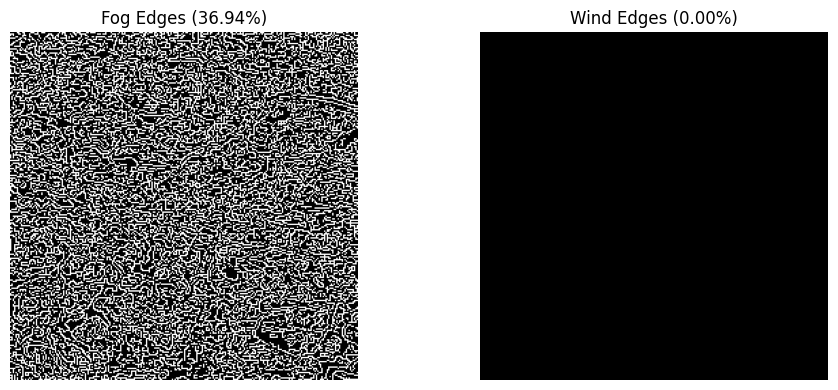

In [32]:
# Loading one augmented sample
fog_sample = np.load(sorted(glob(os.path.join(fog_aug_dir, "*.npy")))[0])
wind_sample = np.load(sorted(glob(os.path.join(wind_aug_dir, "*.npy")))[0])

# Converting to grayscale if needed
def to_grayscale(img):
    if img.ndim == 3:
        return cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    return img.astype(np.uint8)

fog_gray = to_grayscale(fog_sample)
wind_gray = to_grayscale(wind_sample)

# Applying Canny edge detection
fog_edges = cv2.Canny(fog_gray, threshold1=50, threshold2=150)
wind_edges = cv2.Canny(wind_gray, threshold1=50, threshold2=150)

# Calculating edge density
def edge_density(edge_img):
    total_pixels = edge_img.size
    edge_pixels = np.count_nonzero(edge_img)
    return edge_pixels / total_pixels * 100  # in percentage

fog_density = edge_density(fog_edges)
wind_density = edge_density(wind_edges)

print("Fog Edge Density: {:.2f}%".format(fog_density))
print("Wind Edge Density: {:.2f}%".format(wind_density))

# Visualization
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(fog_edges, cmap='gray')
plt.title(f"Fog Edges ({fog_density:.2f}%)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wind_edges, cmap='gray')
plt.title(f"Wind Edges ({wind_density:.2f}%)")
plt.axis('off')

plt.tight_layout()
plt.show()


### **Class Imbalance Consideration**

In this project, class imbalance is not a concern, as the task involves unsupervised image-to-image translation between fog and wind conditions. There are no class labels involved; instead, the goal is to model the transformation from one domain (e.g., fog) to another (e.g., wind). As such, the dataset is treated as two separate image domains, and each domain contributes an equal number of samples post-augmentation. Therefore, traditional class imbalance analysis does not apply in this context.


---




## **Final Texture and Structural Comparison Summary**

To better understand the inherent differences between the **Fog** and **Wind** image domains in our dataset, three key image-level descriptors have been explored and analyzed:

1. **Laplacian Variance** (Blur detection)
2. **Shannon Entropy** (Information content)
3. **Canny Edge Density** (Structural richness)

Each method offers a different perspective into how fog and wind images differ in texture, complexity, and structure.

---

### **Comparison Table**

| Metric                 | Fog (Typical)     | Wind (Typical)    | Interpretation |
|------------------------|-------------------|-------------------|----------------|
| **Laplacian Variance** | ~11,000–11,700     | ~0.004            | Fog is rich in texture, wind is smooth and featureless |
| **Entropy**            | ~7.79 (low)        | ~10.44 (high)     | Wind has higher spatial variability (heatmap-like), fog is uniform |
| **Edge Density**       | ~36.94%            | 0.00%             | Fog has many sharp gradients and edges, wind has none |

---

### **Conclusions**

- **Fog images** consistently show high Laplacian variance, high edge density, and relatively lower entropy. This means they contain **sharp, complex, and structured** textures, typical of natural landscapes captured in visible light conditions.
  
- **Wind images**, in contrast, have near-zero edge content, almost no gradient variation (confirmed by Laplacian variance), but surprisingly **high entropy**. This suggests they represent **spatially rich but smooth scalar fields**, like wind intensity maps — not textures.

---

### **Final Takeaway**

Comparing all three metrics concludes that:

- The **fog and wind domains are structurally and visually distinct**, supporting the need for domain-specific augmentation and translation techniques.

- Additionally, the failure of entropy to differentiate fog images early on prompted deeper, more meaningful analysis through **Laplacian Variance** and **Edge Density**, which together provided a strong case for the domain gap.

- This exploration also demonstrates robustness in experimental design — trying different metrics, interpreting failures (entropy), and validating findings with complementary methods (edges and gradients).

---




## **Final Pipeline & Exploratory Data Analysis (EDA) Summary**

This notebook was focused on building a clean preprocessing and analysis pipeline for paired fog and wind image data. The goal was to prepare the data for future use in domain translation models by ensuring quality, structure, and interpretability.

---

### **Pipeline Overview**

```text
[Raw Fog & Wind data (.tif)]
        ↓
[Preprocessing]
    - Convert to .npy
    - Resize to 256×256
    - Ensure 3 channels
        ↓
[Paired Augmentation]
    - Horizontal Flip
    - Vertical Flip
    - Both Flips
    → Augmented 4× per pair
        ↓
[Saved as: .npy files]
        ↓
[Exploratory Feature Analysis]
    ├── Laplacian Variance (Sharpness)
    ├── Shannon Entropy (Information Content)
    └── Canny Edge Density (Structural Complexity)



### **Key Exploratory Findings**
Laplacian Variance: Fog images showed high sharpness (11,000), while wind images were extremely smooth (0.004), confirming texture difference.

Shannon Entropy: Wind entropy values (10.44) were much higher than fog (7.79), suggesting wind contains more spatial variation and detail.

Edge Density (Canny): Fog images had ~37% edge pixels, while wind had ~0% — indicating fog contains more visual structure.

### **Why This Matters**
Confirms that fog and wind domains differ structurally and statistically.

Augmentation maintains data integrity across both domains.

Provides strong justification for applying domain-aware models such as image-to-image translation techniques.

Identifies potential challenges (e.g., low fog dataset variation) and sets up directions for future dataset improvements.



**- END OF NOTEBOOK 01 -**